In [1]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from model_vit_cnn import Model
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import numpy as np
import torch
import torchvision.models as models

device = "cuda:0"

feature_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
vit = AutoModel.from_pretrained("facebook/dinov2-large")

resnet = models.resnet50(pretrained=True)

model = Model(vit, feature_processor, None)

model.load_state_dict(torch.load("saved_models/checkpoint-best-f1/ours_pre_30epo_1e5_dinov2-large-cnn.bin", map_location=device))
model.to(device)

model.eval()

/home/michael/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/michael/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/michael/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_3859892/1700133942.py:21: FutureWarning: You are using `torch.load` with `weights_only=

Model(
  (vit): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-23): 24 x Dinov2Layer(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
 

### Resnext101

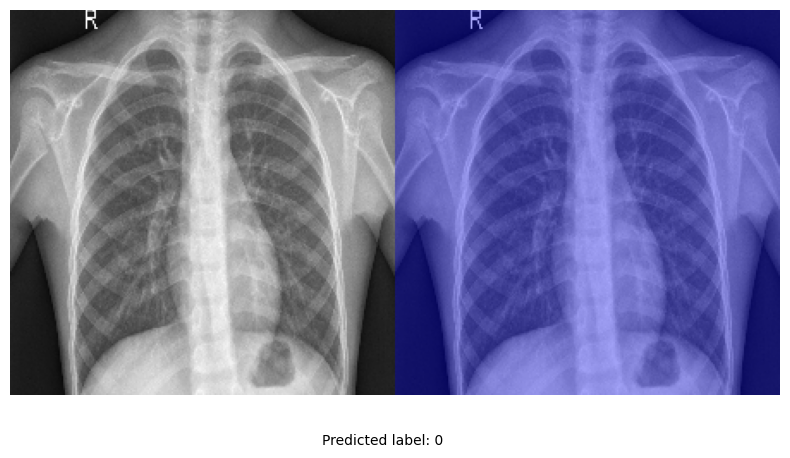

In [4]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms


all_img_files = ["IM-0001-0001.jpeg"]

# SELECTED: person15_virus_46.jpeg
# SELECTED: person110_bacteria_531.jpeg

for img_file in all_img_files:
    img = Image.open(f"../data/chest_xray/test/NORMAL/{img_file}")
    #img = Image.open(f"../data/chest_xray/test/NORMAL/{f}")

    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    img = np.array(img)
    img = cv2.resize(img, (224, 224))
    img = np.float32(img) / 255
    input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    input_tensor = input_tensor.to(device)
    
    # The target for the CAM is the Bear category.
    # As usual for classication, the target is the logit output
    # before softmax, for that category.
    targets = [ClassifierOutputTarget(1)]
    target_layers = [model.cnn] # [model.resnet.layer4]
    
    with torch.no_grad():
        prob = model(input_tensor)
        pred = torch.argmax(prob, dim=1).detach().item()
    
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
    cam = np.uint8(255*grayscale_cams[0, :])
    cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*img), cam_image))
    Image.fromarray(images)
    
    pil_image = Image.fromarray(images)
    # Display using matplotlib
    plt.figure(figsize=(10, 5))
    
    plt.figtext(0.5, 0.01, f"Predicted label: {pred}", ha="center", fontsize=10)
    
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()